In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG16
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

from keras.utils.vis_utils import plot_model

from PIL import Image
import warnings
warnings.filterwarnings("ignore")
random.seed(45)

print(tf.__version__)


C:\Users\logav\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.12.0


In [2]:
import glob
import os
from tqdm import tqdm
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

**LOAD IMAGE DATA AND UNDERSTANDING SOME PROPERTIES OF IMAGE**

In [3]:
# Define the function to get image properties
def image_properties(path):
    # Get a random image from the folder
    for img in random.sample(os.listdir(path), 1):
        print('Image name =', img)
        image = cv.imread(os.path.join(path, img), cv.IMREAD_COLOR)
        break
    
    return image

Image name = 103292.jpg
The dimensions are 640 pixels height and 480 pixels width
The maximum pixel value is 255.00
The minimum pixel value is 0.00
The mean value of the pixels is 120.33
The standard deviation is 69.71


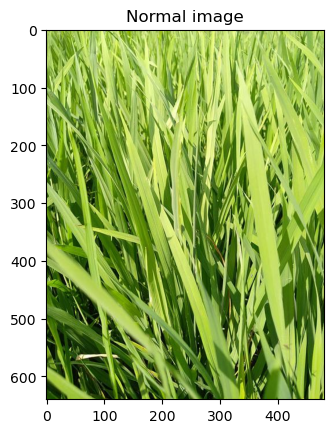

In [4]:
path = r"C:\Users\logav\OneDrive\Desktop\PROJECTS\IDBS\paddy-disease-classification\train_images\normal"

# Retrieve and display the image
image = image_properties(path)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
plt.title('Normal image')

# Display image properties
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.2f}")
print(f"The minimum pixel value is {image.min():.2f}")
print(f"The mean value of the pixels is {image.mean():.2f}")
print(f"The standard deviation is {image.std():.2f}")

**Loading a dataset**

In [5]:
# Define batch size and image dimensions
batch_size = 64
img_height = 256
img_width =  256

# Define data directory for images
data_dir = r"C:\Users\logav\OneDrive\Desktop\PROJECTS\IDBS\paddy-disease-classification\train_images"

**Image Data-Generator**

**Data Normalization And Data Augmentation**

In [6]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

**Training Dataset (70%)**

In [7]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


**Testing Dataset (30%)**

In [8]:
valid_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


**Class Lables**

In [9]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


**Displaying a 9 Random images form dataset**

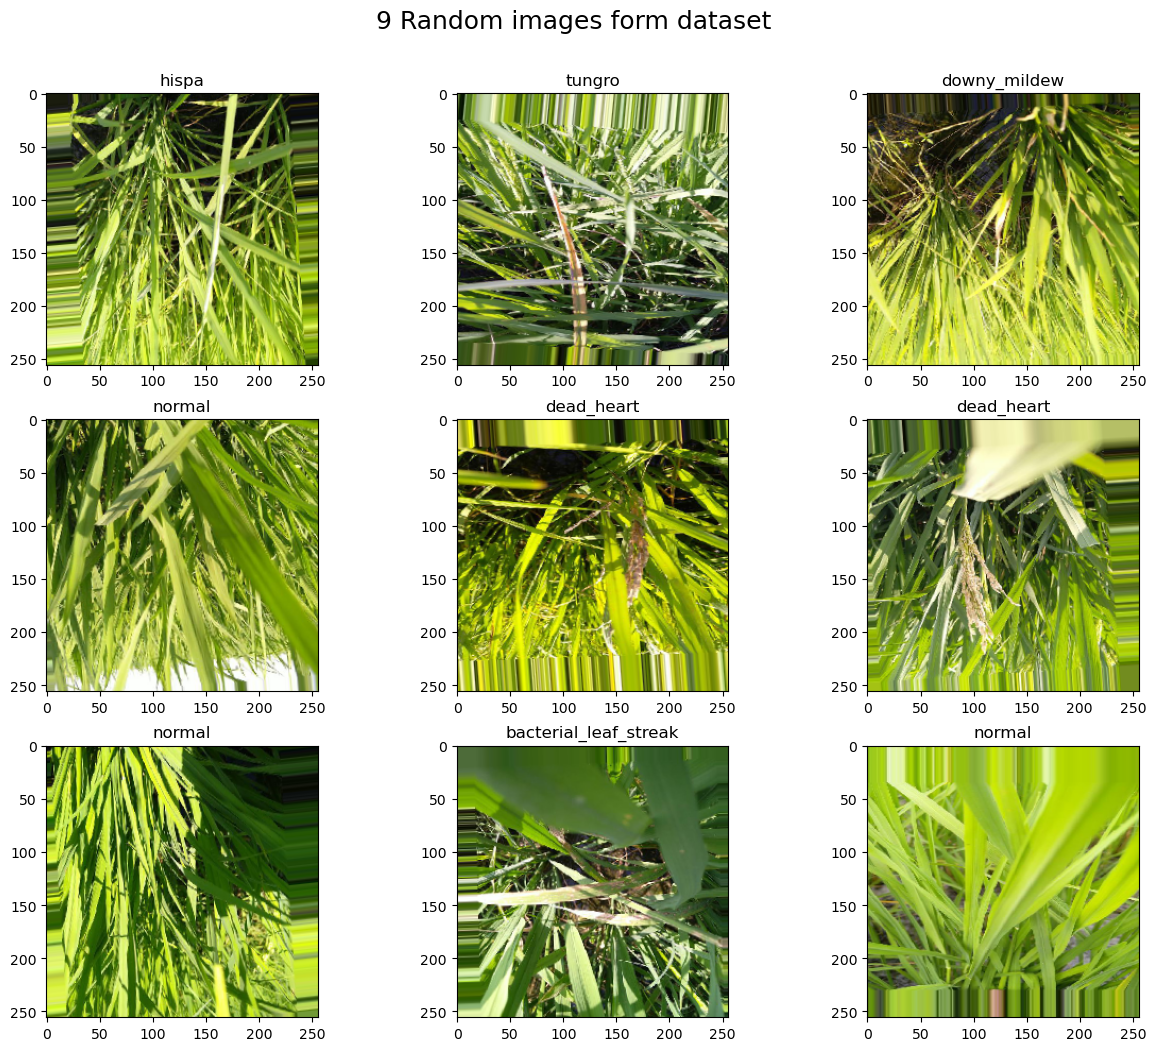

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("9 Random images form dataset", fontsize=18, y=0.95)

for i in range(1,10):
    plt.subplot(3,3,i)
    img, label = train_gen.next()
    plt.title(list(train_gen.class_indices.keys())[np.argmax(label)])
    plt.imshow(img[0])

**CNN Model**

In [11]:
num_classes = 10
input_shape = (batch_size,256,256,3)

In [12]:
num_classes = 10
input_shape = (256, 256, 3)  # Define input shape without batch size

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # 10 output classes
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

**CallBacks**

In [14]:
# terminate if loss was NaN
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [15]:
# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=1,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)]
)

In [17]:
history = model.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=25,
    verbose=1,
    callbacks=[terminate_nan, reduce_lr]
)

Epoch 1/25
114/114 [==============================] - 524s 5s/step - loss: 2.0667 - categorical_accuracy: 0.2578 - val_loss: 1.9571 - val_categorical_accuracy: 0.3241 - lr: 3.0000e-04
Epoch 2/25
114/114 [==============================] - 380s 3s/step - loss: 1.8733 - categorical_accuracy: 0.3396 - val_loss: 1.8124 - val_categorical_accuracy: 0.3536 - lr: 3.0000e-04
Epoch 3/25
114/114 [==============================] - 378s 3s/step - loss: 1.7242 - categorical_accuracy: 0.4075 - val_loss: 1.7015 - val_categorical_accuracy: 0.4168 - lr: 3.0000e-04
Epoch 4/25
114/114 [==============================] - 344s 3s/step - loss: 1.6031 - categorical_accuracy: 0.4472 - val_loss: 1.5722 - val_categorical_accuracy: 0.4469 - lr: 3.0000e-04
Epoch 5/25
114/114 [==============================] - 327s 3s/step - loss: 1.4982 - categorical_accuracy: 0.4863 - val_loss: 1.4648 - val_categorical_accuracy: 0.5014 - lr: 3.0000e-04
Epoch 6/25
114/114 [==============================] - 350s 3s/step - loss: 1.379

**training vs validation loss**

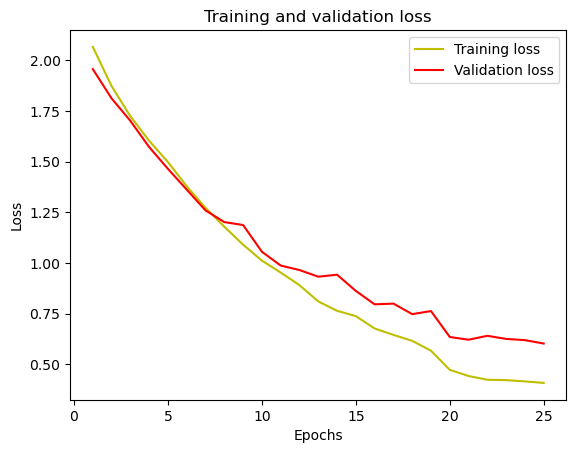

In [18]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Training Accuracy Vs Validation Accuracy**

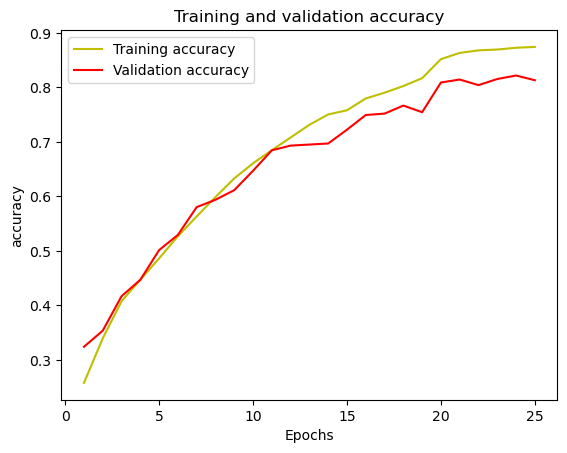

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [20]:
loss, accuracy = model.evaluate(valid_gen)

49/49 [==============================] - 53s 1s/step - loss: 0.6275 - categorical_accuracy: 0.8156


In [21]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.8156460523605347


In [26]:
import sqlite3

# Connect to SQLite database (creates it if it doesn't exist)
conn = sqlite3.connect('crop_disease_db.sqlite')

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Create a table for storing disease information
cursor.execute('''
    CREATE TABLE IF NOT EXISTS disease_info (
        id INTEGER PRIMARY KEY,
        disease_name TEXT,
        remedies TEXT,
        fertilizer TEXT
    )
''')

# Insert sample data with spaces in the disease names
cursor.execute('''
    INSERT INTO disease_info (disease_name, remedies, fertilizer) 
    VALUES 
    ('Bacterial Blight', 'Use resistant varieties, apply copper fungicides.', 'Nitrogen-based fertilizers.'),
    ('Bacterial Leaf Streak', 'Apply copper fungicides, improve field drainage.', 'Use balanced NPK fertilizers.'),
    ('Bacterial Panicle Blight', 'Use resistant varieties, apply bactericides.', 'Apply potash and phosphorus fertilizers.'),
    ('Blast', 'Apply fungicides like tricyclazole or isoprothiolane.', 'Use balanced NPK fertilizers.'),
    ('Brown Spot', 'Use resistant varieties, apply fungicides.', 'Apply nitrogen-based fertilizers.'),
    ('Dead Heart', 'Use insecticides to control pests, ensure proper irrigation.', 'Apply balanced fertilizers.'),
    ('Downy Mildew', 'Apply fungicides such as metalaxyl or mefenoxam.', 'Use phosphorus-rich fertilizers.'),
    ('Hispa', 'Use insecticides to control larvae and adult beetles.', 'Apply balanced NPK fertilizers.'),
    ('Normal', 'No treatment needed, ensure proper crop management.', 'Use regular balanced fertilizers.'),
    ('Tungro', 'Use virus-free seedlings, control green leafhoppers.', 'Apply potash and phosphorus fertilizers.')
''')
# Commit changes and close the connection
conn.commit()
conn.close()


In [27]:
# After training the model
model.save('crop_disease_model.h5')


In [28]:
import ipywidgets as widgets
import sqlite3
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

In [29]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('crop_disease_model.h5')

In [35]:
# Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Resize to match model input shape (256x256)
    image = np.array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Query the database to get remedies and fertilizer for a predicted disease
def get_disease_info(disease_name):
    conn = sqlite3.connect('crop_disease_db.sqlite')
    cursor = conn.cursor()
    cursor.execute("SELECT remedies, fertilizer FROM disease_info WHERE disease_name=?", (disease_name,))
    result = cursor.fetchone()
    conn.close()

    if result:
        remedies, fertilizer = result
        return remedies, fertilizer
    else:
        return None, None

# Map model's predicted label (integer) to disease name (string)
def get_disease_name(predicted_label):
    # Replace this with your actual mapping of labels to disease names
    label_to_disease = {
        0: "Bacterial Blight",
        1: "Bacterial Leaf Streak",
        2: "Bacterial Panicle Blight",
        3: "Blast",
        4: "Brown Spot",
        5: "Dead Heart",
        6: "Downy Mildew",
        7: "Hispa",
        8: "Normal",  # Healthy crop
        9: "Tungro"
    }
    
    return label_to_disease.get(predicted_label[0], "Unknown")

# Button click callback for making prediction
def on_button_click(b):
    image_path = image_path_input.value
    if image_path:
        # Load and preprocess the image
        image = load_and_preprocess_image(image_path)
        
        # Make prediction
        prediction = model.predict(image)
        predicted_label = np.argmax(prediction, axis=1)  # Get the predicted class label
        disease_name = get_disease_name(predicted_label)  # Map label to disease name

        # Query the database for disease info
        remedies, fertilizer = get_disease_info(disease_name)
        
        if remedies and fertilizer:
            print(f"Predicted Disease: {disease_name}")
            print(f"Remedies: {remedies}")
            print(f"Fertilizer: {fertilizer}")
        else:
            print(f"No information found for {disease_name}")

# UI elements
image_path_input = widgets.Text(placeholder='Enter the image path')
button = widgets.Button(description="Predict Disease")

# Display the widgets
display(image_path_input, button)

# Set the button click event to call the prediction function
button.on_click(on_button_click)

Text(value='', placeholder='Enter the image path')

Button(description='Predict Disease', style=ButtonStyle())

1/1 [==============================] - 0s 41ms/step
Predicted Disease: Downy Mildew
Remedies: Apply fungicides such as metalaxyl or mefenoxam.
Fertilizer: Use phosphorus-rich fertilizers.
